# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8- T-tests

#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [2]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "Isavuconazole" #complete name
cond = "Isa" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-06" #date of this analysis
date_info = "2023-06-20" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for any reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [3]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [4]:
##taked all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big

In [5]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      401      901.0      0  CaERG11_0_Fluco_F4_1          0   
1      GCC      401      520.0      0  CaERG11_0_Fluco_F4_1          0   
2      TGC      401      484.0      0  CaERG11_0_Fluco_F4_1          0   
3      TGT      401      777.0      0  CaERG11_0_Fluco_F4_1          0   
4      GAT      401      329.0      0  CaERG11_0_Fluco_F4_1          0   
...    ...      ...        ...    ...                   ...        ...   
2062   GTC      511      471.0      0  CaERG11_0_Fluco_F4_1          0   
2063   TGG      511      635.0      0  CaERG11_0_Fluco_F4_1          0   
2064   TAC      511      708.0      0  CaERG11_0_Fluco_F4_1          0   
2065   TAT      511      431.0      0  CaERG11_0_Fluco_F4_1          0   
2066   TAA      511        NaN      0  CaERG11_0_Fluco_F4_1          0   

     Antifungal Fragment  Replicate  Lane   OD  reads_wanted  reads_before  \
0         Fluco       F4         

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401      409.0      0  CaERG11_0_Posaco_F4_C          0   
1      GCC      401      251.0      0  CaERG11_0_Posaco_F4_C          0   
2      TGC      401      238.0      0  CaERG11_0_Posaco_F4_C          0   
3      TGT      401      376.0      0  CaERG11_0_Posaco_F4_C          0   
4      GAT      401      143.0      0  CaERG11_0_Posaco_F4_C          0   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      191.0      0  CaERG11_0_Posaco_F4_C          0   
2063   TGG      511      322.0      0  CaERG11_0_Posaco_F4_C          0   
2064   TAC      511      328.0      0  CaERG11_0_Posaco_F4_C          0   
2065   TAT      511      214.0      0  CaERG11_0_Posaco_F4_C          0   
2066   TAA      511        NaN      0  CaERG11_0_Posaco_F4_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Posaco       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401       99.0      0  CaERG11_2_Vorico_F4_C          2   
1      GCC      401       71.0      0  CaERG11_2_Vorico_F4_C          2   
2      TGC      401       84.0      0  CaERG11_2_Vorico_F4_C          2   
3      TGT      401      379.0      0  CaERG11_2_Vorico_F4_C          2   
4      GAT      401       42.0      0  CaERG11_2_Vorico_F4_C          2   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      623.0      0  CaERG11_2_Vorico_F4_C          2   
2063   TGG      511      358.0      0  CaERG11_2_Vorico_F4_C          2   
2064   TAC      511       76.0      0  CaERG11_2_Vorico_F4_C          2   
2065   TAT      511       79.0      0  CaERG11_2_Vorico_F4_C          2   
2066   TAA      511        2.0      0  CaERG11_2_Vorico_F4_C          2   

     Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
0        Vorico       F4      

The end
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_c

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      276      304.0      0  CaERG11_0_Fluco_F3_1          0   
1      GCC      276      348.0      0  CaERG11_0_Fluco_F3_1          0   
2      TGC      276      428.0      0  CaERG11_0_Fluco_F3_1          0   
3      TGT      276      262.0      0  CaERG11_0_Fluco_F3_1          0   
4      GAT      276      268.0      0  CaERG11_0_Fluco_F3_1          0   
...    ...      ...        ...    ...                   ...        ...   
2101   GTC      406      386.0      0  CaERG11_0_Fluco_F3_1          0   
2102   TGG      406      257.0      0  CaERG11_0_Fluco_F3_1          0   
2103   TAC      406      583.0      0  CaERG11_0_Fluco_F3_1          0   
2104   TAT      406      274.0      0  CaERG11_0_Fluco_F3_1          0   
2105   TAA      406        1.0      0  CaERG11_0_Fluco_F3_1          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0         Fluco       F3        

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      276      214.0      0  CaERG11_0_Vorico_F3_B          0   
1      GCC      276      312.0      0  CaERG11_0_Vorico_F3_B          0   
2      TGC      276      371.0      0  CaERG11_0_Vorico_F3_B          0   
3      TGT      276      227.0      0  CaERG11_0_Vorico_F3_B          0   
4      GAT      276      220.0      0  CaERG11_0_Vorico_F3_B          0   
...    ...      ...        ...    ...                    ...        ...   
2101   GTC      406      325.0      0  CaERG11_0_Vorico_F3_B          0   
2102   TGG      406      270.0      0  CaERG11_0_Vorico_F3_B          0   
2103   TAC      406      513.0      0  CaERG11_0_Vorico_F3_B          0   
2104   TAT      406      232.0      0  CaERG11_0_Vorico_F3_B          0   
2105   TAA      406        NaN      0  CaERG11_0_Vorico_F3_B          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Vorico       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      276       30.0      0  CaERG11_2_Posaco_F3_C          2   
1      GCC      276       26.0      0  CaERG11_2_Posaco_F3_C          2   
2      TGC      276       55.0      0  CaERG11_2_Posaco_F3_C          2   
3      TGT      276       57.0      0  CaERG11_2_Posaco_F3_C          2   
4      GAT      276      798.0      0  CaERG11_2_Posaco_F3_C          2   
...    ...      ...        ...    ...                    ...        ...   
2101   GTC      406      152.0      0  CaERG11_2_Posaco_F3_C          2   
2102   TGG      406       22.0      0  CaERG11_2_Posaco_F3_C          2   
2103   TAC      406      436.0      0  CaERG11_2_Posaco_F3_C          2   
2104   TAT      406      239.0      0  CaERG11_2_Posaco_F3_C          2   
2105   TAA      406        1.0      0  CaERG11_2_Posaco_F3_C          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Posaco       F3       

The end
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_c

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      154      183.0      0  CaERG11_0_Fluco_F2_2          0   
1      GCC      154      271.0      0  CaERG11_0_Fluco_F2_2          0   
2      TGC      154      458.0      0  CaERG11_0_Fluco_F2_2          0   
3      TGT      154      303.0      0  CaERG11_0_Fluco_F2_2          0   
4      GAT      154      468.0      0  CaERG11_0_Fluco_F2_2          0   
...    ...      ...        ...    ...                   ...        ...   
1360   GTC      280      394.0      0  CaERG11_0_Fluco_F2_2          0   
1361   TGG      280      467.0      0  CaERG11_0_Fluco_F2_2          0   
1362   TAC      280      300.0      0  CaERG11_0_Fluco_F2_2          0   
1363   TAT      280      220.0      0  CaERG11_0_Fluco_F2_2          0   
1364   TAA      280        NaN      0  CaERG11_0_Fluco_F2_2          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0         Fluco       F2        

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154      120.0      0  CaERG11_0_Posaco_F2_B          0   
1      GCC      154      200.0      0  CaERG11_0_Posaco_F2_B          0   
2      TGC      154      403.0      0  CaERG11_0_Posaco_F2_B          0   
3      TGT      154      266.0      0  CaERG11_0_Posaco_F2_B          0   
4      GAT      154      317.0      0  CaERG11_0_Posaco_F2_B          0   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280      293.0      0  CaERG11_0_Posaco_F2_B          0   
1361   TGG      280      312.0      0  CaERG11_0_Posaco_F2_B          0   
1362   TAC      280      220.0      0  CaERG11_0_Posaco_F2_B          0   
1363   TAT      280      190.0      0  CaERG11_0_Posaco_F2_B          0   
1364   TAA      280        3.0      0  CaERG11_0_Posaco_F2_B          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Posaco       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154      589.0      0  CaERG11_2_Posaco_F2_A          2   
1      GCC      154     1174.0      0  CaERG11_2_Posaco_F2_A          2   
2      TGC      154      790.0      0  CaERG11_2_Posaco_F2_A          2   
3      TGT      154      658.0      0  CaERG11_2_Posaco_F2_A          2   
4      GAT      154      128.0      0  CaERG11_2_Posaco_F2_A          2   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280       60.0      0  CaERG11_2_Posaco_F2_A          2   
1361   TGG      280     2582.0      0  CaERG11_2_Posaco_F2_A          2   
1362   TAC      280       21.0      0  CaERG11_2_Posaco_F2_A          2   
1363   TAT      280       29.0      0  CaERG11_2_Posaco_F2_A          2   
1364   TAA      280        1.0      0  CaERG11_2_Posaco_F2_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Posaco       F2       

The end
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_C_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_c

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT       55      382.0      0  CaERG11_0_Posaco_F1_A          0   
1      GCC       55      255.0      0  CaERG11_0_Posaco_F1_A          0   
2      TGC       55      358.0      0  CaERG11_0_Posaco_F1_A          0   
3      TGT       55      409.0      0  CaERG11_0_Posaco_F1_A          0   
4      GAT       55      408.0      0  CaERG11_0_Posaco_F1_A          0   
...    ...      ...        ...    ...                    ...        ...   
2998   GTC      162      279.0      0  CaERG11_0_Posaco_F1_A          0   
2999   TGG      162      428.0      0  CaERG11_0_Posaco_F1_A          0   
3000   TAC      162      379.0      0  CaERG11_0_Posaco_F1_A          0   
3001   TAT      162      455.0      0  CaERG11_0_Posaco_F1_A          0   
3002   TAA      162        2.0      0  CaERG11_0_Posaco_F1_A          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Posaco       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT       55      391.0      0  CaERG11_2_Itra_F1_C          2   
1      GCC       55      237.0      0  CaERG11_2_Itra_F1_C          2   
2      TGC       55      350.0      0  CaERG11_2_Itra_F1_C          2   
3      TGT       55      430.0      0  CaERG11_2_Itra_F1_C          2   
4      GAT       55       28.0      0  CaERG11_2_Itra_F1_C          2   
...    ...      ...        ...    ...                  ...        ...   
2998   GTC      162      253.0      0  CaERG11_2_Itra_F1_C          2   
2999   TGG      162      621.0      0  CaERG11_2_Itra_F1_C          2   
3000   TAC      162      664.0      0  CaERG11_2_Itra_F1_C          2   
3001   TAT      162      615.0      0  CaERG11_2_Itra_F1_C          2   
3002   TAA      162        NaN      0  CaERG11_2_Itra_F1_C          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Itra       F1         C  L001  9.301153     

The end


codon position  nbr_reads  index              Condition  Timepoint  \
0       GCT       55      528.0      0  CaERG11_0_Clotri_F1_A          0   
1       GCC       55      386.0      0  CaERG11_0_Clotri_F1_A          0   
2       TGC       55      532.0      0  CaERG11_0_Clotri_F1_A          0   
3       TGT       55      601.0      0  CaERG11_0_Clotri_F1_A          0   
4       GAT       55      628.0      0  CaERG11_0_Clotri_F1_A          0   
...     ...      ...        ...    ...                    ...        ...   
99211   GTC      511      235.0      0    CaERG11_3_None_F4_3          3   
99212   TGG      511      293.0      0    CaERG11_3_None_F4_3          3   
99213   TAC      511      360.0      0    CaERG11_3_None_F4_3          3   
99214   TAT      511      198.0      0    CaERG11_3_None_F4_3          3   
99215   TAA      511        1.0      0    CaERG11_3_None_F4_3          3   

      Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0         Clotri       F1         A  L001  0.000000       5000000   
1         Clotri       F1         A  L001  0.000000       5000000   
2         Clotri       F1         A  L001  0.000000       5000000   
3         Clotri       F1         A  L001  0.000000       5000000   
4         Clotri       F1         A  L001  0.000000       5000000   
...          ...      ...       ...   ...       ...           ...   
99211       None       F4         3  L002  8.291309       2500000   
99212       None       F4         3  L002  8.291309       2500000   
99213       None       F4         3  L002  8.291309       2500000   
99214       None       F4         3  L002  8.291309       2500000   
99215       None       F4         3  L002  8.291309       2500000   

       reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0           5286093            4989961           1113525      4954935   
1           5286093            4989961           1113525      4954935   
2           5286093            4989961           1113525      4954935   
3           5286093            4989961           1113525      4954935   
4           5286093            4989961           1113525      4954935   
...             ...                ...               ...          ...   
99211       1657998            1625552            449165      1596281   
99212       1657998            1625552            449165      1596281   
99213       1657998            1625552            449165      1596281   
99214       1657998            1625552            449165      1596281   
99215       1657998            1625552            449165      1596281   

       reads_wt  
0        444237  
1        444237  
2        444237  
3        444237  
4        444237  
...         ...  
99211    216412  
99212    216412  
99213    216412  
99214    216412  
99215    216412  

[448812 rows x 17 columns]

# 2- Control between lanes

In [6]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [7]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [8]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads           Condition  Timepoint Antifungal  \
27027    GCT        55      439.0  CaERG11_0_Isa_F1_A          0        Isa   
27028    GCC        55      229.0  CaERG11_0_Isa_F1_A          0        Isa   
27029    TGC        55      420.0  CaERG11_0_Isa_F1_A          0        Isa   
27030    TGT        55      442.0  CaERG11_0_Isa_F1_A          0        Isa   
27031    GAT        55      486.0  CaERG11_0_Isa_F1_A          0        Isa   
...      ...       ...        ...                 ...        ...        ...   
417801   GTT       511      549.0  CaERG11_2_Isa_F4_C          2        Isa   
417802   GTC       511      587.0  CaERG11_2_Isa_F4_C          2        Isa   
417803   TGG       511      526.0  CaERG11_2_Isa_F4_C          2        Isa   
417804   TAC       511       87.0  CaERG11_2_Isa_F4_C          2        Isa   
417805   TAT       511       76.0  CaERG11_2_Isa_F4_C          2        Isa   

       Fragment Replicate  Lane         OD  reads_wanted  reads_before  \
27027        F1         A  L001   0.000000       5000000       4139120   
27028        F1         A  L001   0.000000       5000000       4139120   
27029        F1         A  L001   0.000000       5000000       4139120   
27030        F1         A  L001   0.000000       5000000       4139120   
27031        F1         A  L001   0.000000       5000000       4139120   
...         ...       ...   ...        ...           ...           ...   
417801       F4         C  L001  10.906684       5000000       3159267   
417802       F4         C  L001  10.906684       5000000       3159267   
417803       F4         C  L001  10.906684       5000000       3159267   
417804       F4         C  L001  10.906684       5000000       3159267   
417805       F4         C  L001  10.906684       5000000       3159267   

        reads_after_merge  nbr_reads_single  reads_align  reads_wt  
27027             4076210            855342      4051810    503425  
27028             4076210            855342      4051810    503425  
27029             4076210            855342      4051810    503425  
27030             4076210            855342      4051810    503425  
27031             4076210            855342      4051810    503425  
...                   ...               ...          ...       ...  
417801            3146473            938463      3115877    279742  
417802            3146473            938463      3115877    279742  
417803            3146473            938463      3115877    279742  
417804            3146473            938463      3115877    279742  
417805            3146473            938463      3115877    279742  

[48858 rows x 16 columns]

In [9]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_Isa_F1_A        55   AAA          0        Isa       F1   
1      CaERG11_0_Isa_F1_A        55   AAC          0        Isa       F1   
2      CaERG11_0_Isa_F1_A        55   AAG          0        Isa       F1   
3      CaERG11_0_Isa_F1_A        55   AAT          0        Isa       F1   
4      CaERG11_0_Isa_F1_A        55   ACC          0        Isa       F1   
...                   ...       ...   ...        ...        ...      ...   
48853  CaERG11_2_Isa_F4_C       511   TGT          2        Isa       F4   
48854  CaERG11_2_Isa_F4_C       511   TTA          2        Isa       F4   
48855  CaERG11_2_Isa_F4_C       511   TTC          2        Isa       F4   
48856  CaERG11_2_Isa_F4_C       511   TTG          2        Isa       F4   
48857  CaERG11_2_Isa_F4_C       511   TTT          2        Isa       F4   

      Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0             A   0.000000      380.0       5000000       4139120   
1             A   0.000000      312.0       5000000       4139120   
2             A   0.000000      447.0       5000000       4139120   
3             A   0.000000      288.0       5000000       4139120   
4             A   0.000000      218.0       5000000       4139120   
...         ...        ...        ...           ...           ...   
48853         C  10.906684      953.0       5000000       3159267   
48854         C  10.906684      561.0       5000000       3159267   
48855         C  10.906684      854.0       5000000       3159267   
48856         C  10.906684      598.0       5000000       3159267   
48857         C  10.906684      858.0       5000000       3159267   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4076210            855342      4051810    503425  
1                4076210            855342      4051810    503425  
2                4076210            855342      4051810    503425  
3                4076210            855342      4051810    503425  
4                4076210            855342      4051810    503425  
...                  ...               ...          ...       ...  
48853            3146473            938463      3115877    279742  
48854            3146473            938463      3115877    279742  
48855            3146473            938463      3115877    279742  
48856            3146473            938463      3115877    279742  
48857            3146473            938463      3115877    279742  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


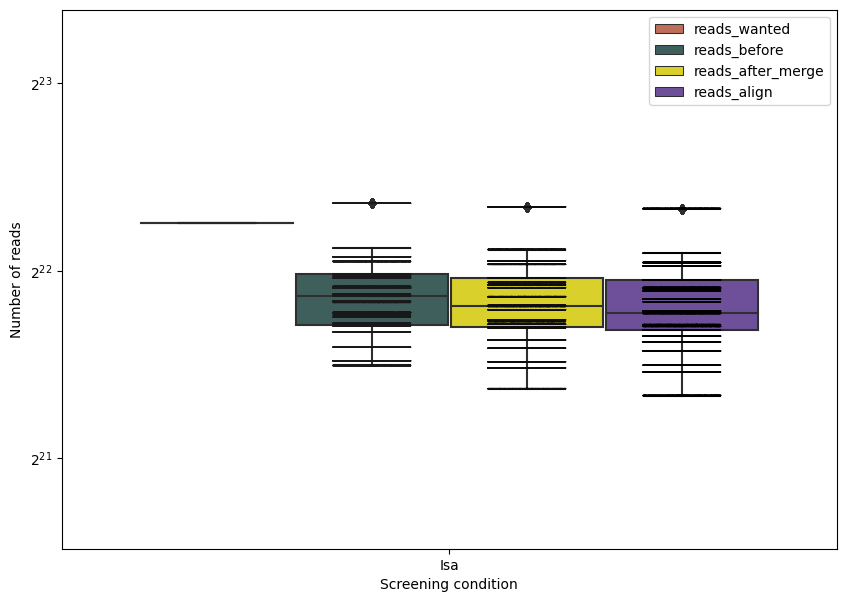

In [10]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [11]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [12]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index           Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Isa_F1_A        55   AAA          0        Isa   
1          1  CaERG11_0_Isa_F1_A        55   AAC          0        Isa   
2          2  CaERG11_0_Isa_F1_A        55   AAG          0        Isa   
3          3  CaERG11_0_Isa_F1_A        55   AAT          0        Isa   
4          4  CaERG11_0_Isa_F1_A        55   ACC          0        Isa   
...      ...                 ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Isa_F4_C       511   TGT          2        Isa   
47948  48854  CaERG11_2_Isa_F4_C       511   TTA          2        Isa   
47949  48855  CaERG11_2_Isa_F4_C       511   TTC          2        Isa   
47950  48856  CaERG11_2_Isa_F4_C       511   TTG          2        Isa   
47951  48857  CaERG11_2_Isa_F4_C       511   TTT          2        Isa   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000      380.0       5000000       4139120   
1           F1         A   0.000000      312.0       5000000       4139120   
2           F1         A   0.000000      447.0       5000000       4139120   
3           F1         A   0.000000      288.0       5000000       4139120   
4           F1         A   0.000000      218.0       5000000       4139120   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.906684      953.0       5000000       3159267   
47948       F4         C  10.906684      561.0       5000000       3159267   
47949       F4         C  10.906684      854.0       5000000       3159267   
47950       F4         C  10.906684      598.0       5000000       3159267   
47951       F4         C  10.906684      858.0       5000000       3159267   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4076210            855342      4051810    503425  
1                4076210            855342      4051810    503425  
2                4076210            855342      4051810    503425  
3                4076210            855342      4051810    503425  
4                4076210            855342      4051810    503425  
...                  ...               ...          ...       ...  
47947            3146473            938463      3115877    279742  
47948            3146473            938463      3115877    279742  
47949            3146473            938463      3115877    279742  
47950            3146473            938463      3115877    279742  
47951            3146473            938463      3115877    279742  

[47952 rows x 16 columns]

In [13]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

df_sum=df_sum.reset_index()
df_sum = df_sum.drop("index",axis=1)

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [14]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

level_0           Condition  position codon  Timepoint Antifungal  \
0            0  CaERG11_0_Isa_F1_A        55   AAA          0        Isa   
1            1  CaERG11_0_Isa_F1_A        55   AAC          0        Isa   
2            2  CaERG11_0_Isa_F1_A        55   AAG          0        Isa   
3            3  CaERG11_0_Isa_F1_A        55   AAT          0        Isa   
4            4  CaERG11_0_Isa_F1_A        55   ACC          0        Isa   
...        ...                 ...       ...   ...        ...        ...   
47947    47947  CaERG11_2_Isa_F4_C       511   TGT          2        Isa   
47948    47948  CaERG11_2_Isa_F4_C       511   TTA          2        Isa   
47949    47949  CaERG11_2_Isa_F4_C       511   TTC          2        Isa   
47950    47950  CaERG11_2_Isa_F4_C       511   TTG          2        Isa   
47951    47951  CaERG11_2_Isa_F4_C       511   TTT          2        Isa   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000      380.0       5000000       4139120   
1           F1         A   0.000000      312.0       5000000       4139120   
2           F1         A   0.000000      447.0       5000000       4139120   
3           F1         A   0.000000      288.0       5000000       4139120   
4           F1         A   0.000000      218.0       5000000       4139120   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.906684      953.0       5000000       3159267   
47948       F4         C  10.906684      561.0       5000000       3159267   
47949       F4         C  10.906684      854.0       5000000       3159267   
47950       F4         C  10.906684      598.0       5000000       3159267   
47951       F4         C  10.906684      858.0       5000000       3159267   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                4076210            855342      4051810    503425   
1                4076210            855342      4051810    503425   
2                4076210            855342      4051810    503425   
3                4076210            855342      4051810    503425   
4                4076210            855342      4051810    503425   
...                  ...               ...          ...       ...   
47947            3146473            938463      3115877    279742   
47948            3146473            938463      3115877    279742   
47949            3146473            938463      3115877    279742   
47950            3146473            938463      3115877    279742   
47951            3146473            938463      3115877    279742   

       nbr_reads_log  norm_reads  norm_reads_log  
0           8.573647    0.000094      -13.376488  
1           8.290019    0.000077      -13.660116  
2           8.807355    0.000111      -13.142780  
3           8.174926    0.000071      -13.775209  
4           7.774787    0.000054      -14.175348  
...              ...         ...             ...  
47947       9.897845    0.000306      -11.673361  
47948       9.134426    0.000180      -12.436781  
47949       9.739781    0.000274      -11.831426  
47950       9.226412    0.000192      -12.344795  
47951       9.746514    0.000276      -11.824693  

[47952 rows x 19 columns]

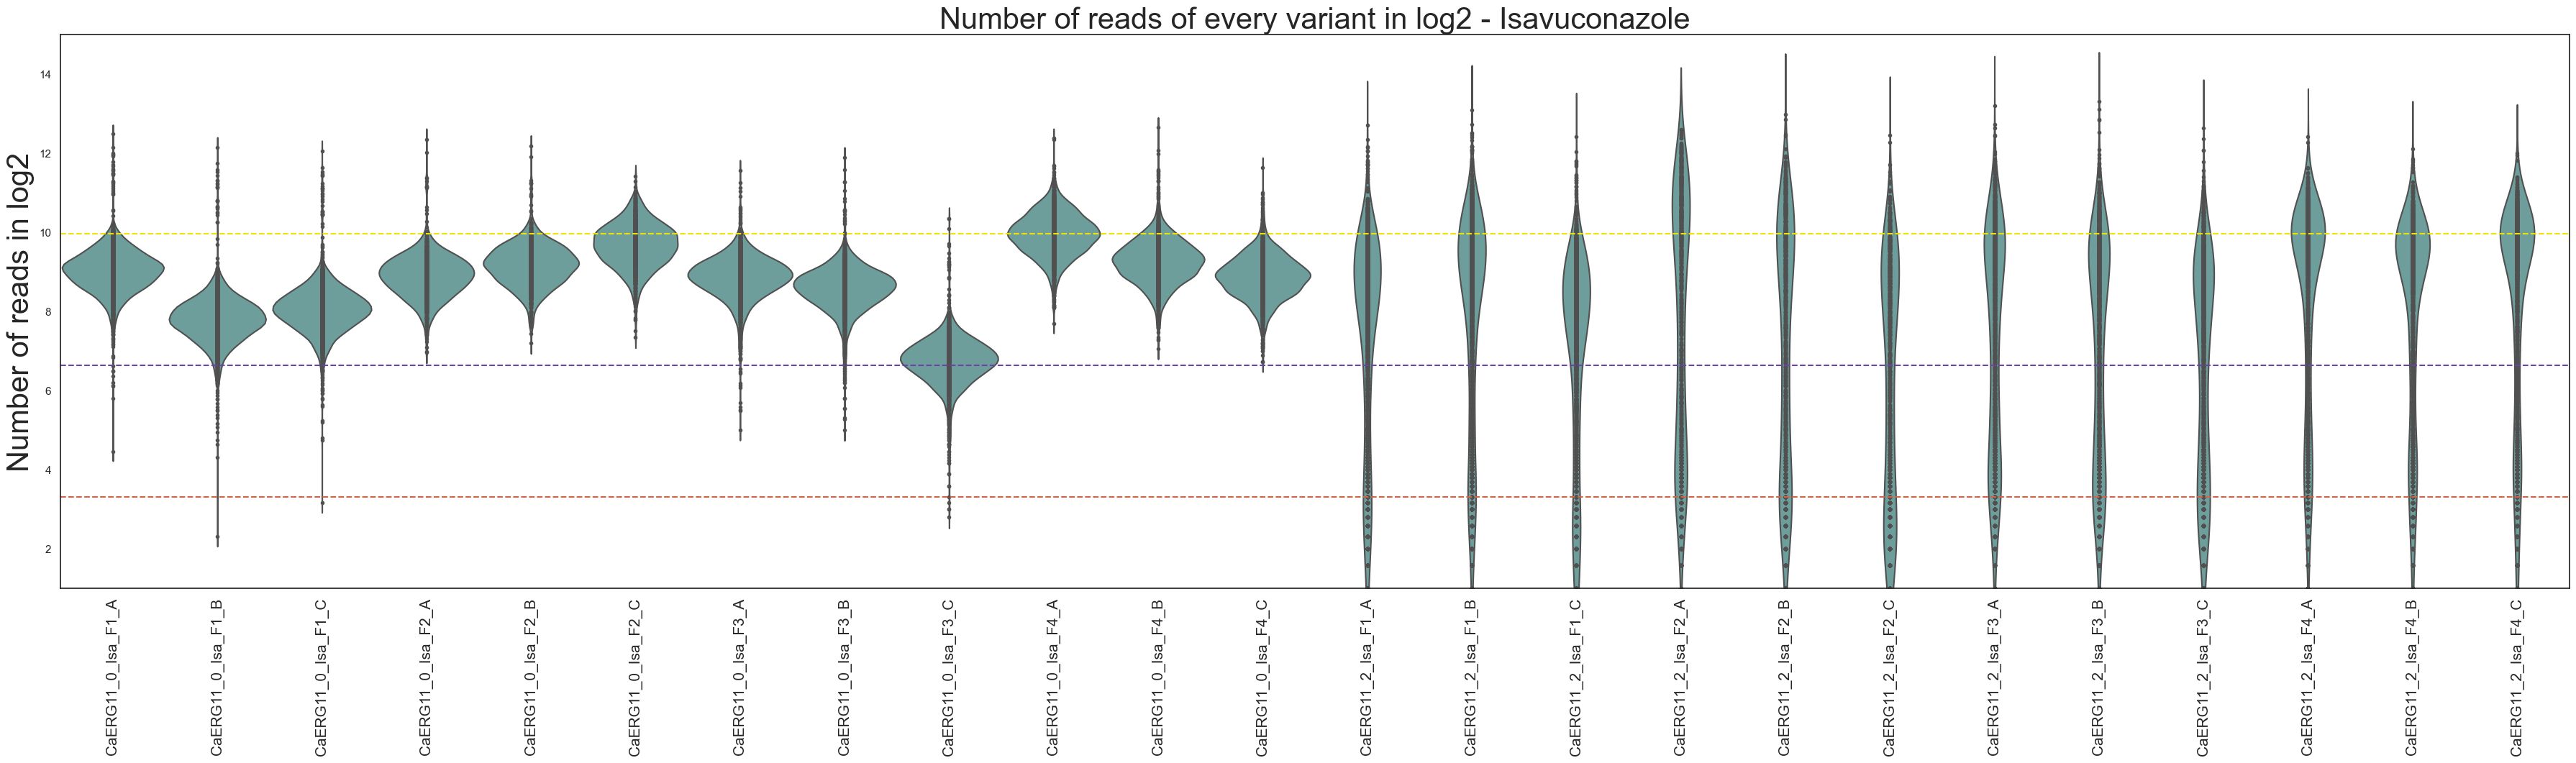

In [15]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [16]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2
0                55   AAA        Isa       F1         A  0.000094  0.000006
1                55   AAA        Isa       F1         B  0.000040  0.000011
2                55   AAA        Isa       F1         C  0.000054  0.000008
3                55   AAC        Isa       F1         A  0.000077  0.000024
4                55   AAC        Isa       F1         B  0.000023  0.000028
...             ...   ...        ...      ...       ...       ...       ...
23971           511   TTG        Isa       F4         B  0.000117  0.000128
23972           511   TTG        Isa       F4         C  0.000112  0.000192
23973           511   TTT        Isa       F4         A  0.000166  0.000324
23974           511   TTT        Isa       F4         B  0.000095  0.000229
23975           511   TTT        Isa       F4         C  0.000077  0.000276

[23976 rows x 7 columns]

In [17]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment Replicate  nbr_tp0  nbr_tp2
0                55   AAA        Isa       F1         A    380.0     21.0
1                55   AAA        Isa       F1         B    210.0     35.0
2                55   AAA        Isa       F1         C    233.0     33.0
3                55   AAC        Isa       F1         A    312.0     80.0
4                55   AAC        Isa       F1         B    122.0     90.0
...             ...   ...        ...      ...       ...      ...      ...
23971           511   TTG        Isa       F4         B    522.0    430.0
23972           511   TTG        Isa       F4         C    423.0    598.0
23973           511   TTT        Isa       F4         A    643.0    956.0
23974           511   TTT        Isa       F4         B    425.0    768.0
23975           511   TTT        Isa       F4         C    291.0    858.0

[23976 rows x 7 columns]

In [18]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment Replicate  OD_tp0     OD_tp2
0                55   AAA        Isa       F1         A     0.0  11.055908
1                55   AAA        Isa       F1         B     0.0  11.127027
2                55   AAA        Isa       F1         C     0.0  11.082791
3                55   AAC        Isa       F1         A     0.0  11.055908
4                55   AAC        Isa       F1         B     0.0  11.127027
...             ...   ...        ...      ...       ...     ...        ...
23971           511   TTG        Isa       F4         B     0.0  10.855634
23972           511   TTG        Isa       F4         C     0.0  10.906684
23973           511   TTT        Isa       F4         A     0.0  10.899206
23974           511   TTT        Isa       F4         B     0.0  10.855634
23975           511   TTT        Isa       F4         C     0.0  10.906684

[23976 rows x 7 columns]

In [19]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA        Isa       F1         A  0.000094  0.000006   
1                55   AAA        Isa       F1         B  0.000040  0.000011   
2                55   AAA        Isa       F1         C  0.000054  0.000008   
3                55   AAC        Isa       F1         A  0.000077  0.000024   
4                55   AAC        Isa       F1         B  0.000023  0.000028   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG        Isa       F4         B  0.000117  0.000128   
23972           511   TTG        Isa       F4         C  0.000112  0.000192   
23973           511   TTT        Isa       F4         A  0.000166  0.000324   
23974           511   TTT        Isa       F4         B  0.000095  0.000229   
23975           511   TTT        Isa       F4         C  0.000077  0.000276   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  
0            380.0     21.0     0.0  11.055908  
1            210.0     35.0     0.0  11.127027  
2            233.0     33.0     0.0  11.082791  
3            312.0     80.0     0.0  11.055908  
4            122.0     90.0     0.0  11.127027  
...            ...      ...     ...        ...  
23971        522.0    430.0     0.0  10.855634  
23972        423.0    598.0     0.0  10.906684  
23973        643.0    956.0     0.0  10.899206  
23974        425.0    768.0     0.0  10.855634  
23975        291.0    858.0     0.0  10.906684  

[23976 rows x 11 columns]

In [20]:
#log2foldchange calculation

merged_df['log2(tp2/tp0)'] = np.log2((df_wide_tp["freq_tp2"] / df_wide_tp["freq_tp0"]))

 


merged_df = merged_df.rename(columns={'log2(tp2/tp0)': 'l2fc_0_2'})

merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA        Isa       F1         A  0.000094  0.000006   
1                55   AAA        Isa       F1         B  0.000040  0.000011   
2                55   AAA        Isa       F1         C  0.000054  0.000008   
3                55   AAC        Isa       F1         A  0.000077  0.000024   
4                55   AAC        Isa       F1         B  0.000023  0.000028   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG        Isa       F4         B  0.000117  0.000128   
23972           511   TTG        Isa       F4         C  0.000112  0.000192   
23973           511   TTT        Isa       F4         A  0.000166  0.000324   
23974           511   TTT        Isa       F4         B  0.000095  0.000229   
23975           511   TTT        Isa       F4         C  0.000077  0.000276   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  
0            380.0     21.0     0.0  11.055908 -3.866795  
1            210.0     35.0     0.0  11.127027 -1.840197  
2            233.0     33.0     0.0  11.082791 -2.764867  
3            312.0     80.0     0.0  11.055908 -1.702748  
4            122.0     90.0     0.0  11.127027  0.276257  
...            ...      ...     ...        ...       ...  
23971        522.0    430.0     0.0  10.855634  0.132064  
23972        423.0    598.0     0.0  10.906684  0.775242  
23973        643.0    956.0     0.0  10.899206  0.967823  
23974        425.0    768.0     0.0  10.855634  1.263317  
23975        291.0    858.0     0.0  10.906684  1.833440  

[23976 rows x 12 columns]

In [21]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA        Isa       F1         A  0.000094  0.000006   
1                55   AAA        Isa       F1         B  0.000040  0.000011   
2                55   AAA        Isa       F1         C  0.000054  0.000008   
3                55   AAC        Isa       F1         A  0.000077  0.000024   
4                55   AAC        Isa       F1         B  0.000023  0.000028   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG        Isa       F4         B  0.000117  0.000128   
23972           511   TTG        Isa       F4         C  0.000112  0.000192   
23973           511   TTT        Isa       F4         A  0.000166  0.000324   
23974           511   TTT        Isa       F4         B  0.000095  0.000229   
23975           511   TTT        Isa       F4         C  0.000077  0.000276   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            380.0     21.0     0.0  11.055908 -3.866795  K  
1            210.0     35.0     0.0  11.127027 -1.840197  K  
2            233.0     33.0     0.0  11.082791 -2.764867  K  
3            312.0     80.0     0.0  11.055908 -1.702748  N  
4            122.0     90.0     0.0  11.127027  0.276257  N  
...            ...      ...     ...        ...       ... ..  
23971        522.0    430.0     0.0  10.855634  0.132064  L  
23972        423.0    598.0     0.0  10.906684  0.775242  L  
23973        643.0    956.0     0.0  10.899206  0.967823  F  
23974        425.0    768.0     0.0  10.855634  1.263317  F  
23975        291.0    858.0     0.0  10.906684  1.833440  F  

[23976 rows x 13 columns]

In [22]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [24]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [25]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment Replicate  freq_tp0  \
0             21        55   ATC        Isa       F1         A  0.000081   
1             22        55   ATC        Isa       F1         B  0.000016   
2             23        55   ATC        Isa       F1         C  0.000048   
3             27        55   ATT        Isa       F1         A  0.000114   
4             28        55   ATT        Isa       F1         B  0.000040   
..           ...       ...   ...        ...      ...       ...       ...   
799        23965       511   TTA        Isa       F4         B  0.000094   
800        23966       511   TTA        Isa       F4         C  0.000085   
801        23970       511   TTG        Isa       F4         A  0.000208   
802        23971       511   TTG        Isa       F4         B  0.000117   
803        23972       511   TTG        Isa       F4         C  0.000112   

Timepoint  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0          0.000066    329.0    224.0     0.0  11.055908 -0.305121  I  
1          0.000109     85.0    349.0     0.0  11.127027  2.735923  I  
2          0.000057    206.0    242.0     0.0  11.082791  0.249361  I  
3          0.000105    459.0    358.0     0.0  11.055908 -0.110230  I  
4          0.000168    208.0    539.0     0.0  11.127027  2.080434  I  
..              ...      ...      ...     ...        ...       ... ..  
799        0.000110    420.0    368.0     0.0  10.855634  0.220988  L  
800        0.000180    320.0    561.0     0.0  10.906684  1.084747  L  
801        0.000199    809.0    588.0     0.0  10.899206 -0.063289  L  
802        0.000128    522.0    430.0     0.0  10.855634  0.132064  L  
803        0.000192    423.0    598.0     0.0  10.906684  0.775242  L  

[804 rows x 14 columns]

In [26]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    print(first_row['codon'])
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

ATC
ATC
ATC
ATT
ATT
ATT
TTT
TTT
TTT
GGA
GGA
GGA
GGT
GGT
GGT
TCC
TCC
TCC
TCT
TCT
TCT
GCC
GCC
GCC
GCT
GCT
GCT
GCC
GCC
GCC
GCT
GCT
GCT
TCC
TCC
TCC
TAC
TAC
TAC
GGA
GGA
GGA
CAG
CAG
CAG
CAG
CAG
CAG
CCA
CCA
CCA
CCT
CCT
CCT
TAC
TAC
TAC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTA
TTA
TTA
TTG
TTG
TTG
TTA
TTA
TTA
TTG
TTG
TTG
GGA
GGA
GGA
GGT
GGT
GGT
AAG
AAG
AAG
GTC
GTC
GTC
GTT
GTT
GTT
GGA
GGA
GGA
CAT
CAT
CAT
GAG
GAG
GAG
TTC
TTC
TTC
GTT
GTT
GTT
TTT
TTT
TTT
AAC
AAC
AAC
GCC
GCC
GCC
GCT
GCT
GCT
TTG
TTG
TTG
GTT
GTT
GTT
TCC
TCC
TCC
GCC
GCC
GCC
GAG
GAG
GAG
GAC
GAC
GAC
GCC
GCC
GCC
GCT
GCT
GCT
TAT
TAT
TAT
AAG
AAG
AAG
CAT
CAT
CAT
TTG
TTG
TTG
ACC
ACC
ACC
ACT
ACT
ACT
ACC
ACC
ACC
CCA
CCA
CCA
CCT
CCT
CCT
GTC
GTC
GTC
GTT
GTT
GTT
TTT
TTT
TTT
GGT
GGT
GGT
AAA
AAA
AAA
GGT
GGT
GGT
GTC
GTC
GTC
ATT
ATT
ATT
TAT
TAT
TAT
GAC
GAC
GAC
TGC
TGC
TGC
CCA
CCA
CCA
CCT
CCT
CCT
AAT
AAT
AAT
TCC
TCC
TCC
TCT
TCT
TCT
AGA
AGA
AGA
TTA
TTA
TTA
TTG
TTG
TTG
GAA
GAA
GAA
CAA
CAA
CAA
AAG
AAG
AAG
AAA
AAA
AAA
TTC
TTC
TTC
GCC
GCC
GCC
AAG
AAG
AAG
TTT


Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   ATC        Isa       F1         A  0.000081  0.000066   
1                55   ATC        Isa       F1         B  0.000016  0.000109   
2                55   ATC        Isa       F1         C  0.000048  0.000057   
3                55   ATT        Isa       F1         A  0.000114  0.000105   
4                55   ATT        Isa       F1         B  0.000040  0.000168   
..              ...   ...        ...      ...       ...       ...       ...   
799             511   TTA        Isa       F4         B  0.000094  0.000110   
800             511   TTA        Isa       F4         C  0.000085  0.000180   
801             511   TTG        Isa       F4         A  0.000208  0.000199   
802             511   TTG        Isa       F4         B  0.000117  0.000128   
803             511   TTG        Isa       F4         C  0.000112  0.000192   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            329.0    224.0     0.0  11.055908 -0.305121  I  
1             85.0    349.0     0.0  11.127027  2.735923  I  
2            206.0    242.0     0.0  11.082791  0.249361  I  
3            459.0    358.0     0.0  11.055908 -0.110230  I  
4            208.0    539.0     0.0  11.127027  2.080434  I  
..             ...      ...     ...        ...       ... ..  
799          420.0    368.0     0.0  10.855634  0.220988  L  
800          320.0    561.0     0.0  10.906684  1.084747  L  
801          809.0    588.0     0.0  10.899206 -0.063289  L  
802          522.0    430.0     0.0  10.855634  0.132064  L  
803          423.0    598.0     0.0  10.906684  0.775242  L  

[804 rows x 13 columns]

In [27]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")
f1_wtA = wt_frag1_r.get_group("A").reset_index()
f1_wtB = wt_frag1_r.get_group("B").reset_index()
f1_wtC = wt_frag1_r.get_group("C").reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wtA = wt_frag2_r.get_group("A").reset_index()
f2_wtB = wt_frag2_r.get_group("B").reset_index()
f2_wtC = wt_frag2_r.get_group("C").reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wtA = wt_frag3_r.get_group("A").reset_index()
f3_wtB = wt_frag3_r.get_group("B").reset_index()
f3_wtC = wt_frag3_r.get_group("C").reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wtA = wt_frag4_r.get_group("A").reset_index()
f4_wtB = wt_frag4_r.get_group("B").reset_index()
f4_wtC = wt_frag4_r.get_group("C").reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")
m1_A = m1r.get_group("A").reset_index()
m1_B = m1r.get_group("B").reset_index()
m1_C = m1r.get_group("C").reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_A = m2r.get_group("A").reset_index()
m2_B = m2r.get_group("B").reset_index()
m2_C = m2r.get_group("C").reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_A = m3r.get_group("A").reset_index()
m3_B = m3r.get_group("B").reset_index()
m3_C = m3r.get_group("C").reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_A = m4r.get_group("A").reset_index()
m4_B = m4r.get_group("B").reset_index()
m4_C = m4r.get_group("C").reset_index()


In [28]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

0.0001548377645938
0.0002399294055058
8.624235272887912e-05


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA        Isa       F1         A   
1                1      3        55   AAC        Isa       F1         A   
2                2      6        55   AAG        Isa       F1         A   
3                3      9        55   AAT        Isa       F1         A   
4                4     12        55   ACC        Isa       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
2832          2832   8930       162   TGT        Isa       F1         C   
2833          2833   8936       162   TTA        Isa       F1         C   
2834          2834   8942       162   TTC        Isa       F1         C   
2835          2835   8948       162   TTG        Isa       F1         C   
2836          2836   8954       162   TTT        Isa       F1         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000094  0.000006    380.0     21.0     0.0  11.055908 -3.866795   
1          0.000077  0.000024    312.0     80.0     0.0  11.055908 -1.702748   
2          0.000111  0.000002    447.0      6.0     0.0  11.055908 -5.752580   
3          0.000071  0.000019    288.0     65.0     0.0  11.055908 -1.883111   
4          0.000054  0.000042    218.0    142.0     0.0  11.055908 -0.367495   
...             ...       ...      ...      ...     ...        ...       ...   
2832       0.000040  0.000035    170.0    148.0     0.0  11.082791 -0.180649   
2833       0.000071  0.000045    305.0    189.0     0.0  11.082791 -0.669497   
2834       0.000058  0.000028    248.0    117.0     0.0  11.082791 -1.059324   
2835       0.000060  0.000041    260.0    176.0     0.0  11.082791 -0.542265   
2836       0.000062  0.000023    268.0     97.0     0.0  11.082791 -1.438717   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.361693  11.055908  
1          N    -0.165956  11.055908  
2          K    -0.532261  11.055908  
3          N    -0.182270  11.055908  
4          T    -0.045183  11.055908  
...       ..          ...        ...  
2832       C    -0.044739  11.082791  
2833       L    -0.088848  11.082791  
2834       F    -0.124022  11.082791  
2835       L    -0.077368  11.082791  
2836       F    -0.158255  11.082791  

[8511 rows x 17 columns]

In [29]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.0003903059661704
0.00025062420789045
0.000133201763011


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   8067       154   AAA        Isa       F2         A   
1                1   8073       154   AAC        Isa       F2         A   
2                2   8079       154   AAG        Isa       F2         A   
3                3   8085       154   AAT        Isa       F2         A   
4                4   8091       154   ACC        Isa       F2         A   
...            ...    ...       ...   ...        ...      ...       ...   
1151          1151  12287       280   TGT        Isa       F2         C   
1152          1152  12293       280   TTA        Isa       F2         C   
1153          1153  12299       280   TTC        Isa       F2         C   
1154          1154  12305       280   TTG        Isa       F2         C   
1155          1155  12311       280   TTT        Isa       F2         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000101  0.000637    361.0   2381.0     0.0  10.415644  2.658699   
1          0.000097  0.000132    348.0    494.0     0.0  10.415644  0.444789   
2          0.000107  0.000730    383.0   2728.0     0.0  10.415644  2.769781   
3          0.000069  0.000084    248.0    314.0     0.0  10.415644  0.279793   
4          0.000113  0.000131    404.0    490.0     0.0  10.415644  0.218388   
...             ...       ...      ...      ...     ...        ...       ...   
1151       0.000247  0.000004    846.0     13.0     0.0  10.589272 -5.909421   
1152       0.000094  0.000074    322.0    250.0     0.0  10.589272 -0.354405   
1153       0.000150  0.000026    514.0     88.0     0.0  10.589272 -2.523253   
1154       0.000155  0.000094    533.0    319.0     0.0  10.589272 -0.729326   
1155       0.000114  0.000029    389.0     99.0     0.0  10.589272 -1.954032   

Timepoint aa  select_coef    nbr_gen  
0          K     0.111100  10.415644  
1          N    -0.101457  10.415644  
2          K     0.121765  10.415644  
3          N    -0.117298  10.415644  
4          T    -0.123193  10.415644  
...       ..          ...        ...  
1151       C    -0.484495  10.589272  
1152       L     0.040094  10.589272  
1153       F    -0.164722  10.589272  
1154       L     0.004688  10.589272  
1155       F    -0.110967  10.589272  

[3468 rows x 17 columns]

In [30]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.0002237766515315
0.00018382044906015
0.0001516770368508


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  11646       276   AAA        Isa       F3         A   
1                1  11652       276   AAC        Isa       F3         A   
2                2  11658       276   AAG        Isa       F3         A   
3                3  11664       276   AAT        Isa       F3         A   
4                4  11670       276   ACC        Isa       F3         A   
...            ...    ...       ...   ...        ...      ...       ...   
2014          2014  18680       406   TGT        Isa       F3         C   
2015          2015  18686       406   TTA        Isa       F3         C   
2016          2016  18692       406   TTC        Isa       F3         C   
2017          2017  18698       406   TTG        Isa       F3         C   
2018          2018  18704       406   TTT        Isa       F3         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000164  0.000434    473.0   1701.0     0.0  10.77653  1.399037   
1          0.000115  0.000286    331.0   1120.0     0.0  10.77653  1.310296   
2          0.000156  0.000446    448.0   1749.0     0.0  10.77653  1.517333   
3          0.000179  0.000467    515.0   1830.0     0.0  10.77653  1.381954   
4          0.000164  0.000398    473.0   1559.0     0.0  10.77653  1.273352   
...             ...       ...      ...      ...     ...       ...       ...   
2014       0.000025  0.000090     66.0    322.0     0.0  10.80919  1.831180   
2015       0.000062  0.000203    163.0    724.0     0.0  10.80919  1.706164   
2016       0.000021  0.000076     55.0    272.0     0.0  10.80919  1.847281   
2017       0.000040  0.000178    105.0    638.0     0.0  10.80919  2.153631   
2018       0.000040  0.000128    104.0    457.0     0.0  10.80919  1.686837   

Timepoint aa  select_coef   nbr_gen  
0          K     0.097359  10.77653  
1          N     0.089124  10.77653  
2          K     0.108336  10.77653  
3          N     0.095773  10.77653  
4          T     0.085696  10.77653  
...       ..          ...       ...  
2014       C     0.010660  10.80919  
2015       L    -0.000905  10.80919  
2016       F     0.012150  10.80919  
2017       L     0.040492  10.80919  
2018       F    -0.002693  10.80919  

[6057 rows x 17 columns]

In [31]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"] 
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

0.0002641735359678
0.0001911480895298
0.00025594720202365


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  17367       401   AAA        Isa       F4         A   
1                1  17373       401   AAC        Isa       F4         A   
2                2  17379       401   AAG        Isa       F4         A   
3                3  17385       401   AAT        Isa       F4         A   
4                4  17391       401   ACC        Isa       F4         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT        Isa       F4         C   
1976          1976  23966       511   TTA        Isa       F4         C   
1977          1977  23969       511   TTC        Isa       F4         C   
1978          1978  23972       511   TTG        Isa       F4         C   
1979          1979  23975       511   TTT        Isa       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000192  0.000003    747.0      8.0     0.0  10.899206 -5.980605   
1          0.000377  0.000053   1467.0    156.0     0.0  10.899206 -2.828651   
2          0.000272  0.000003   1058.0      8.0     0.0  10.899206 -6.482197   
3          0.000212  0.000022    822.0     65.0     0.0  10.899206 -3.243990   
4          0.000252  0.000033    980.0     98.0     0.0  10.899206 -2.912388   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000119  0.000306    449.0    953.0     0.0  10.906684  1.360814   
1976       0.000085  0.000180    320.0    561.0     0.0  10.906684  1.084747   
1977       0.000073  0.000274    276.0    854.0     0.0  10.906684  1.902789   
1978       0.000112  0.000192    423.0    598.0     0.0  10.906684  0.775242   
1979       0.000077  0.000276    291.0    858.0     0.0  10.906684  1.833440   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.548070  10.899206  
1          N    -0.258878  10.899206  
2          K    -0.594091  10.899206  
3          N    -0.296986  10.899206  
4          T    -0.266561  10.899206  
...       ..          ...        ...  
1975       C     0.041805  10.906684  
1976       L     0.016493  10.906684  
1977       F     0.091497  10.906684  
1978       L    -0.011885  10.906684  
1979       F     0.085138  10.906684  

[5940 rows x 17 columns]

In [32]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA        Isa       F1         A   
1                1      3        55   AAC        Isa       F1         A   
2                2      6        55   AAG        Isa       F1         A   
3                3      9        55   AAT        Isa       F1         A   
4                4     12        55   ACC        Isa       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT        Isa       F4         C   
1976          1976  23966       511   TTA        Isa       F4         C   
1977          1977  23969       511   TTC        Isa       F4         C   
1978          1978  23972       511   TTG        Isa       F4         C   
1979          1979  23975       511   TTT        Isa       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000094  0.000006    380.0     21.0     0.0  11.055908 -3.866795   
1          0.000077  0.000024    312.0     80.0     0.0  11.055908 -1.702748   
2          0.000111  0.000002    447.0      6.0     0.0  11.055908 -5.752580   
3          0.000071  0.000019    288.0     65.0     0.0  11.055908 -1.883111   
4          0.000054  0.000042    218.0    142.0     0.0  11.055908 -0.367495   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000119  0.000306    449.0    953.0     0.0  10.906684  1.360814   
1976       0.000085  0.000180    320.0    561.0     0.0  10.906684  1.084747   
1977       0.000073  0.000274    276.0    854.0     0.0  10.906684  1.902789   
1978       0.000112  0.000192    423.0    598.0     0.0  10.906684  0.775242   
1979       0.000077  0.000276    291.0    858.0     0.0  10.906684  1.833440   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.361693  11.055908  
1          N    -0.165956  11.055908  
2          K    -0.532261  11.055908  
3          N    -0.182270  11.055908  
4          T    -0.045183  11.055908  
...       ..          ...        ...  
1975       C     0.041805  10.906684  
1976       L     0.016493  10.906684  
1977       F     0.091497  10.906684  
1978       L    -0.011885  10.906684  
1979       F     0.085138  10.906684  

[23976 rows x 17 columns]

# 4- Control between replicates

In [33]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

<Axes:xlabel='Replicate', ylabel='Replicate'>

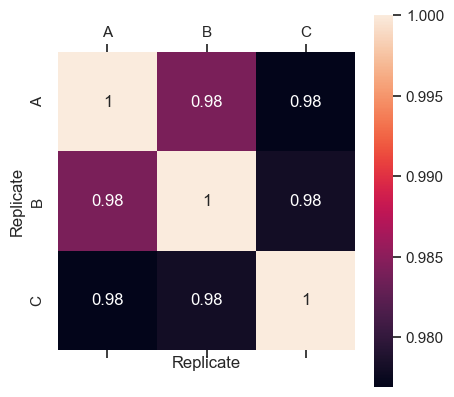

In [34]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

In [35]:
df_r

position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0           55   AAA        Isa       F1         A  0.000094  0.000006   
1           55   AAC        Isa       F1         A  0.000077  0.000024   
2           55   AAG        Isa       F1         A  0.000111  0.000002   
3           55   AAT        Isa       F1         A  0.000071  0.000019   
4           55   ACC        Isa       F1         A  0.000054  0.000042   
...        ...   ...        ...      ...       ...       ...       ...   
1975       511   TGT        Isa       F4         C  0.000119  0.000306   
1976       511   TTA        Isa       F4         C  0.000085  0.000180   
1977       511   TTC        Isa       F4         C  0.000073  0.000274   
1978       511   TTG        Isa       F4         C  0.000112  0.000192   
1979       511   TTT        Isa       F4         C  0.000077  0.000276   

      nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  select_coef    nbr_gen  
0       380.0     21.0     0.0  11.055908 -3.866795  K    -0.361693  11.055908  
1       312.0     80.0     0.0  11.055908 -1.702748  N    -0.165956  11.055908  
2       447.0      6.0     0.0  11.055908 -5.752580  K    -0.532261  11.055908  
3       288.0     65.0     0.0  11.055908 -1.883111  N    -0.182270  11.055908  
4       218.0    142.0     0.0  11.055908 -0.367495  T    -0.045183  11.055908  
...       ...      ...     ...        ...       ... ..          ...        ...  
1975    449.0    953.0     0.0  10.906684  1.360814  C     0.041805  10.906684  
1976    320.0    561.0     0.0  10.906684  1.084747  L     0.016493  10.906684  
1977    276.0    854.0     0.0  10.906684  1.902789  F     0.091497  10.906684  
1978    423.0    598.0     0.0  10.906684  0.775242  L    -0.011885  10.906684  
1979    291.0    858.0     0.0  10.906684  1.833440  F     0.085138  10.906684  

[23976 rows x 15 columns]

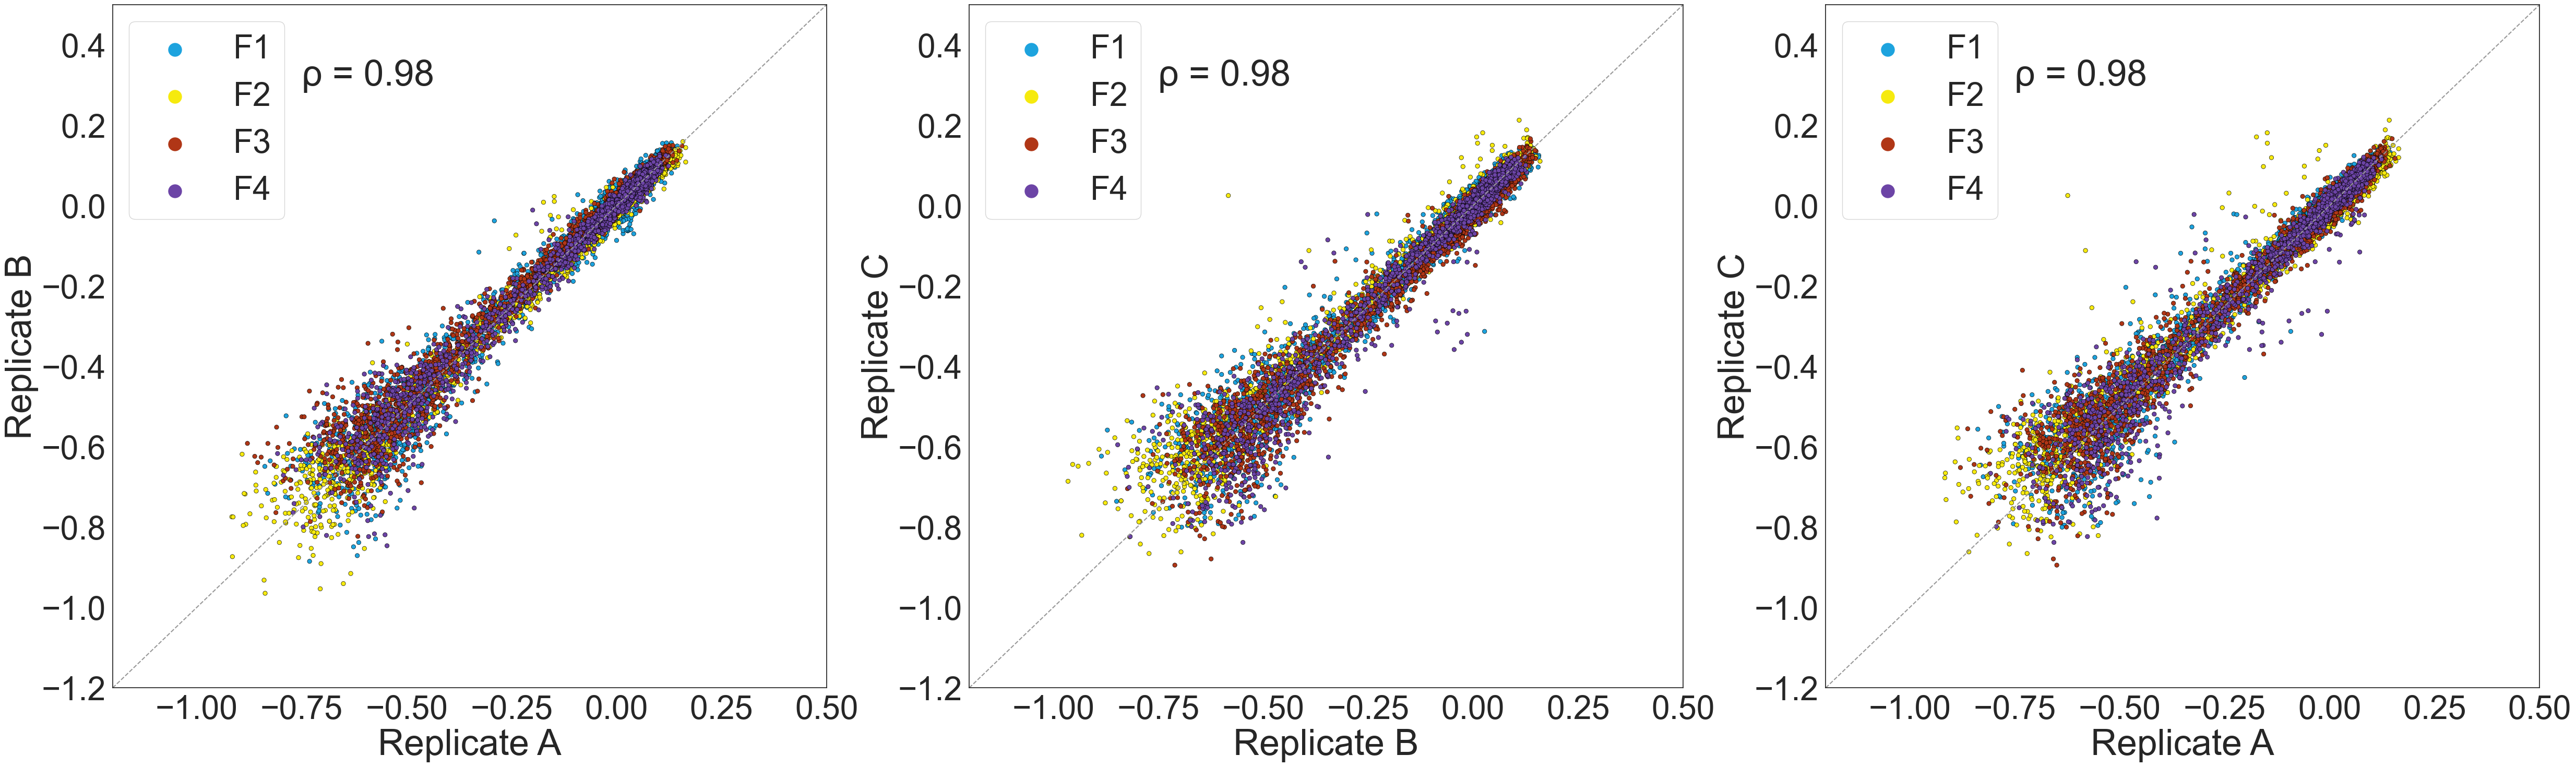

In [36]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")


r_list = ["A","B","A"]


r2_list = ["B","C","C"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    

    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep1["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_list[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_list[i]), fontsize=50)
    
    #title = "Replicate " + str(r_list[i]) + " and Replicate " + str(r2_list[i])
    #axes[row].set_title(title, fontsize=55)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.3, text , fontsize = 50)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)


plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [37]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA        Isa       F1  K  0.000054  0.000008 -2.764867   
1           55   AAC        Isa       F1  N  0.000041  0.000024 -1.702748   
2           55   AAG        Isa       F1  K  0.000056  0.000002 -4.584849   
3           55   AAT        Isa       F1  N  0.000022  0.000019 -1.012339   
4           55   ACC        Isa       F1  T  0.000032  0.000042 -0.309130   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT        Isa       F4  C  0.000127  0.000306  0.830678   
7988       511   TTA        Isa       F4  L  0.000094  0.000139  0.220988   
7989       511   TTC        Isa       F4  F  0.000079  0.000268  1.457438   
7990       511   TTG        Isa       F4  L  0.000117  0.000192  0.132064   
7991       511   TTT        Isa       F4  F  0.000095  0.000276  1.263317   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       233.0     33.0  11.082791    -0.361693  
1       178.0     80.0  11.082791    -0.184652  
2       242.0      8.0  11.082791    -0.528106  
3        97.0     65.0  11.082791    -0.161020  
4       137.0    142.0  11.082791    -0.045183  
...       ...      ...        ...          ...  
7987    565.0    937.0  10.899206     0.041805  
7988    420.0    409.0  10.899206    -0.013350  
7989    352.0    791.0  10.899206     0.091497  
7990    522.0    588.0  10.899206    -0.011885  
7991    425.0    858.0  10.899206     0.085138  

[7992 rows x 12 columns]

# 5- Control between codons

In [38]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA        Isa       F1  K  0.000054  0.000008 -2.764867   
1           55   AAC        Isa       F1  N  0.000041  0.000024 -1.702748   
2           55   AAG        Isa       F1  K  0.000056  0.000002 -4.584849   
3           55   AAT        Isa       F1  N  0.000022  0.000019 -1.012339   
4           55   ACC        Isa       F1  T  0.000032  0.000042 -0.309130   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT        Isa       F4  C  0.000127  0.000306  0.830678   
7988       511   TTA        Isa       F4  L  0.000094  0.000139  0.220988   
7989       511   TTC        Isa       F4  F  0.000079  0.000268  1.457438   
7990       511   TTG        Isa       F4  L  0.000117  0.000192  0.132064   
7991       511   TTT        Isa       F4  F  0.000095  0.000276  1.263317   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       233.0     33.0  11.082791    -0.361693  
1       178.0     80.0  11.082791    -0.184652  
2       242.0      8.0  11.082791    -0.528106  
3        97.0     65.0  11.082791    -0.161020  
4       137.0    142.0  11.082791    -0.045183  
...       ...      ...        ...          ...  
7987    565.0    937.0  10.899206     0.041805  
7988    420.0    409.0  10.899206    -0.013350  
7989    352.0    791.0  10.899206     0.091497  
7990    522.0    588.0  10.899206    -0.011885  
7991    425.0    858.0  10.899206     0.085138  

[7992 rows x 12 columns]

In [39]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

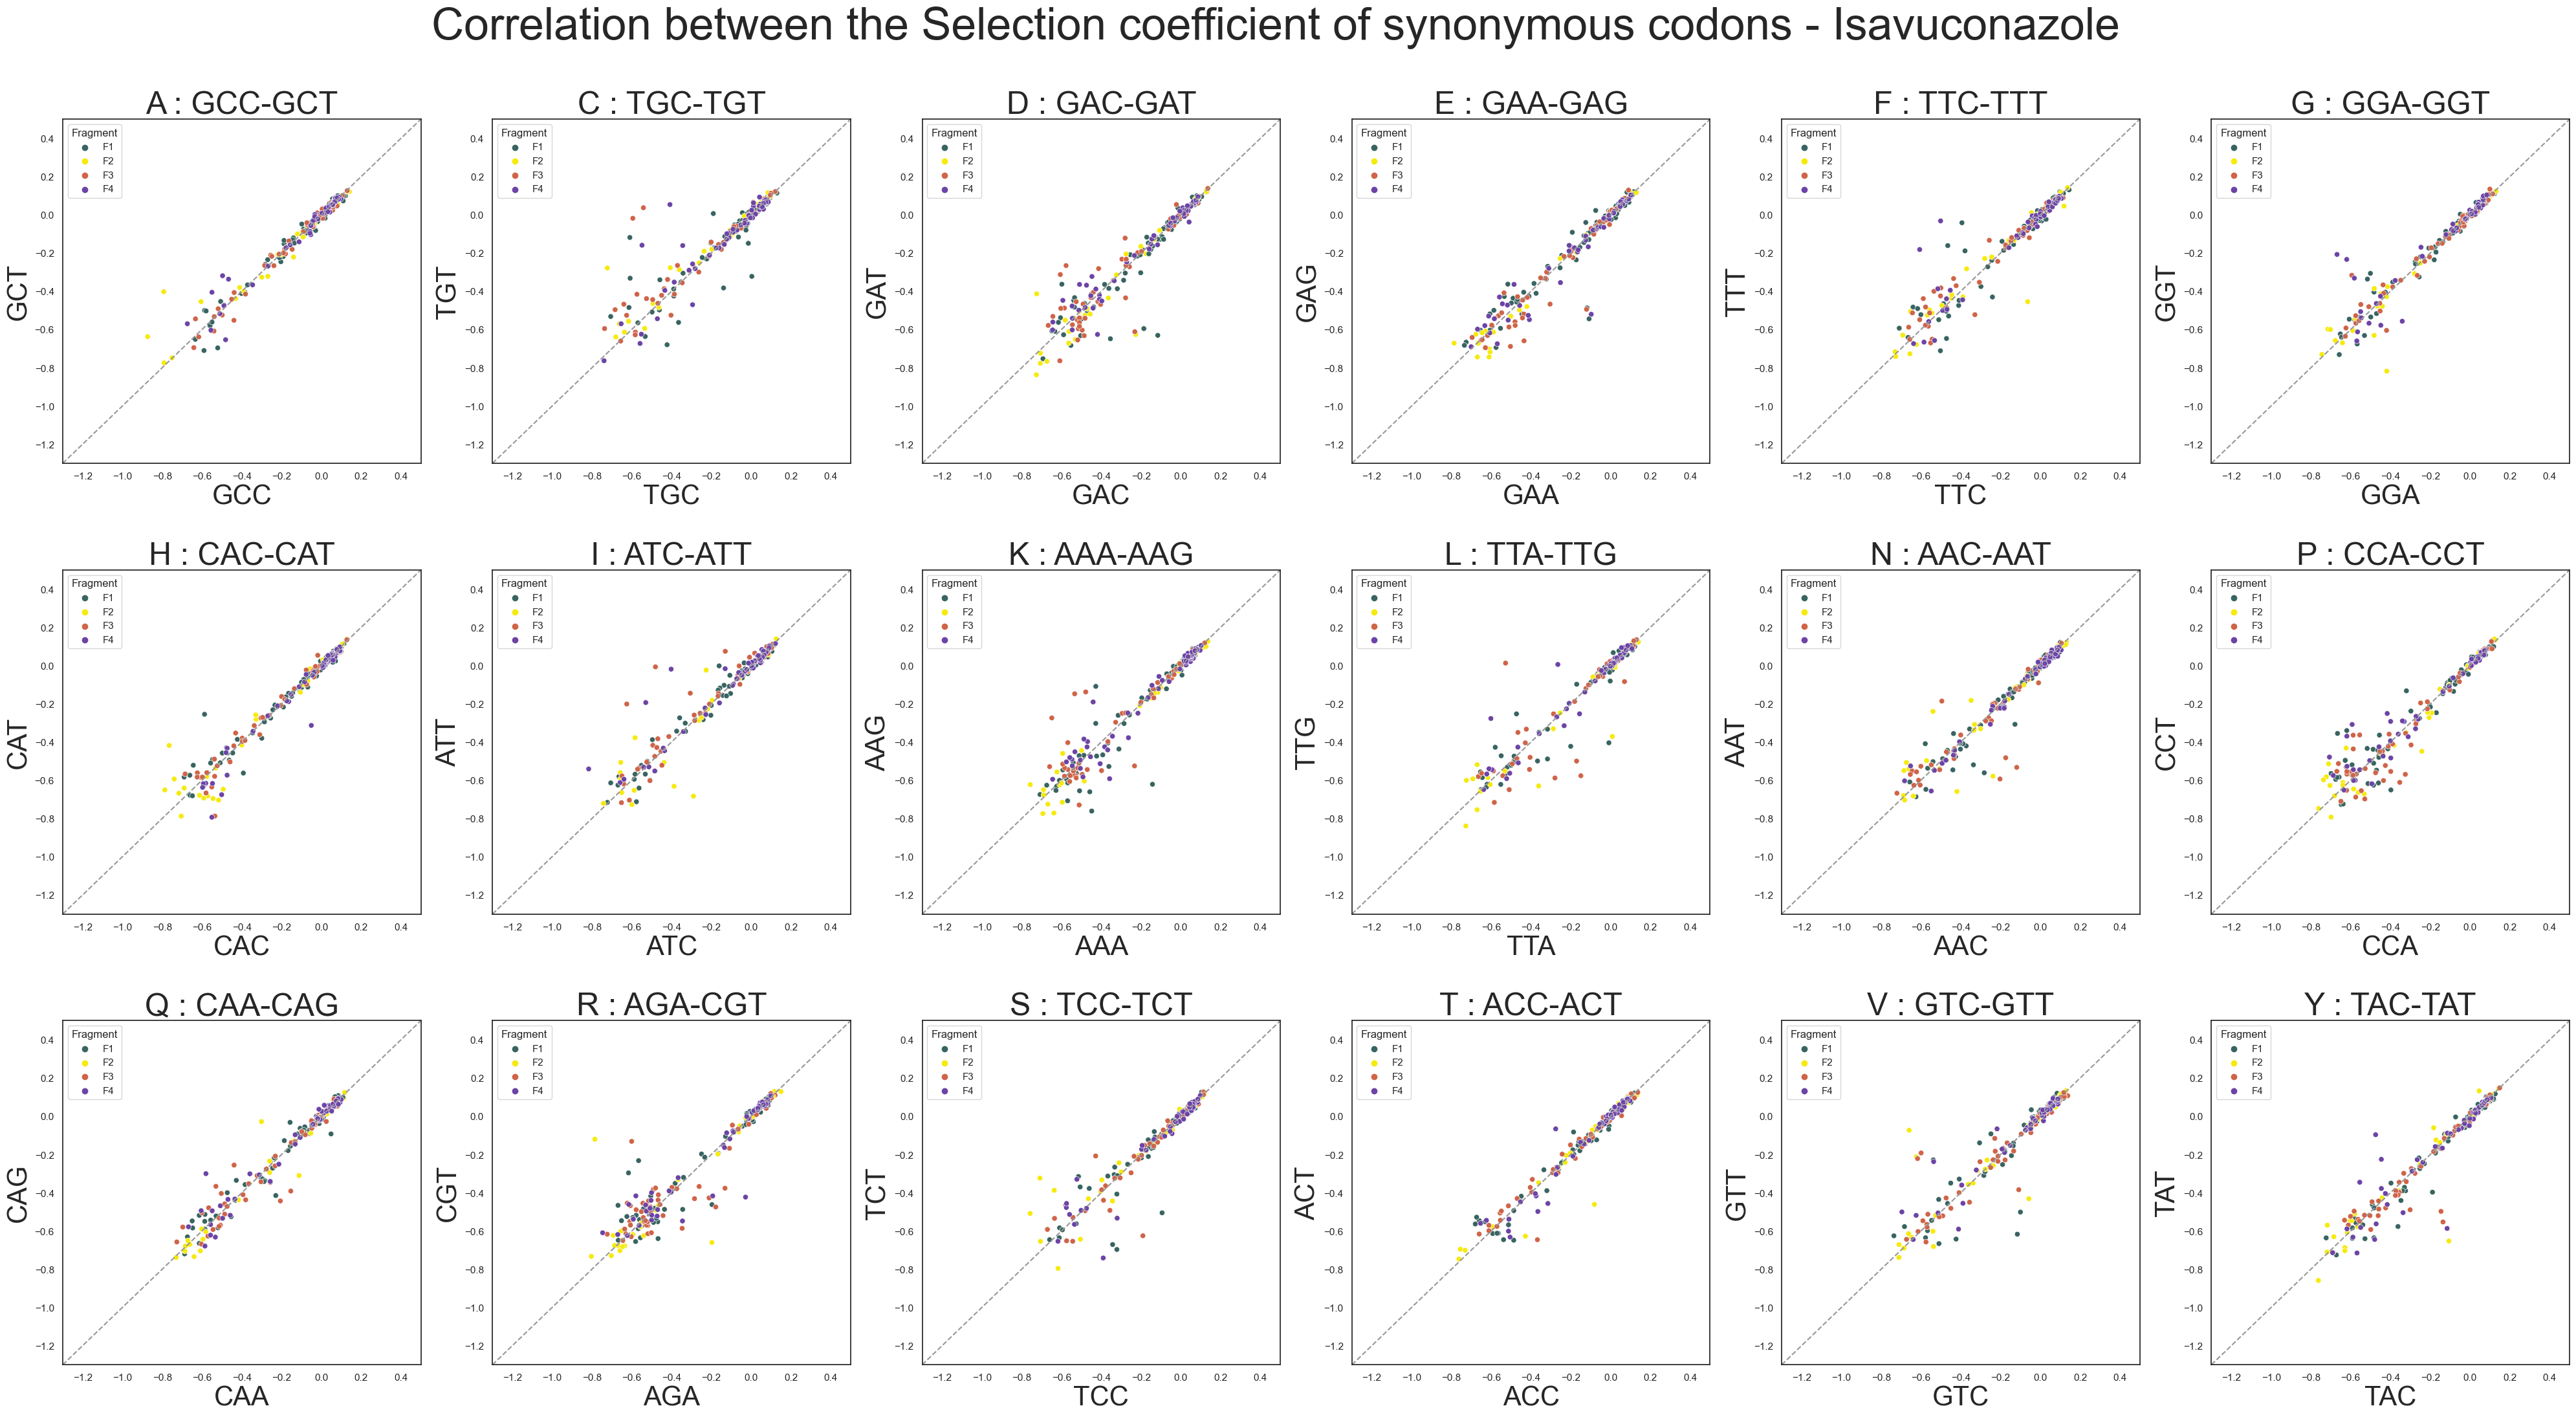

In [41]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals
        
    result = sp.stats.spearmanr(codon1["select_coef"],codon2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    #text = "Spearman's ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    #axes[row].text(-1.17,0.1, text , fontsize = 20)
    
    #Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [42]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6- Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [43]:
name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [44]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp2  l2fc_0_2  nbr_tp0  \
0           55  *        Isa       F1  0.000056  0.000003 -4.590774    243.0   
1           55  A        Isa       F1  0.000042  0.000074 -0.000286    189.0   
2           55  C        Isa       F1  0.000046  0.000087  0.056469    197.5   
3           55  D        Isa       F1  0.000044  0.000006 -3.642646    189.0   
4           55  E        Isa       F1  0.000056  0.000007 -3.434321    240.5   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S        Isa       F4  0.000100  0.000242  0.955214    442.0   
4278       511  T        Isa       F4  0.000110  0.000184  0.417594    491.5   
4279       511  V        Isa       F4  0.000091  0.000179  0.609211    407.0   
4280       511  W        Isa       F4  0.000105  0.000169  0.358037    469.0   
4281       511  Y        Isa       F4  0.000094  0.000025 -2.329563    418.0   

      nbr_tp2  select_coef  
0         9.0    -0.469618  
1       252.0    -0.028465  
2       297.5    -0.024723  
3        20.0    -0.373713  
4        22.0    -0.372056  
...       ...          ...  
4277    736.0     0.055202  
4278    569.5     0.004844  
4279    528.5     0.034597  
4280    526.0    -0.000725  
4281     71.5    -0.246231  

[4282 rows x 10 columns]

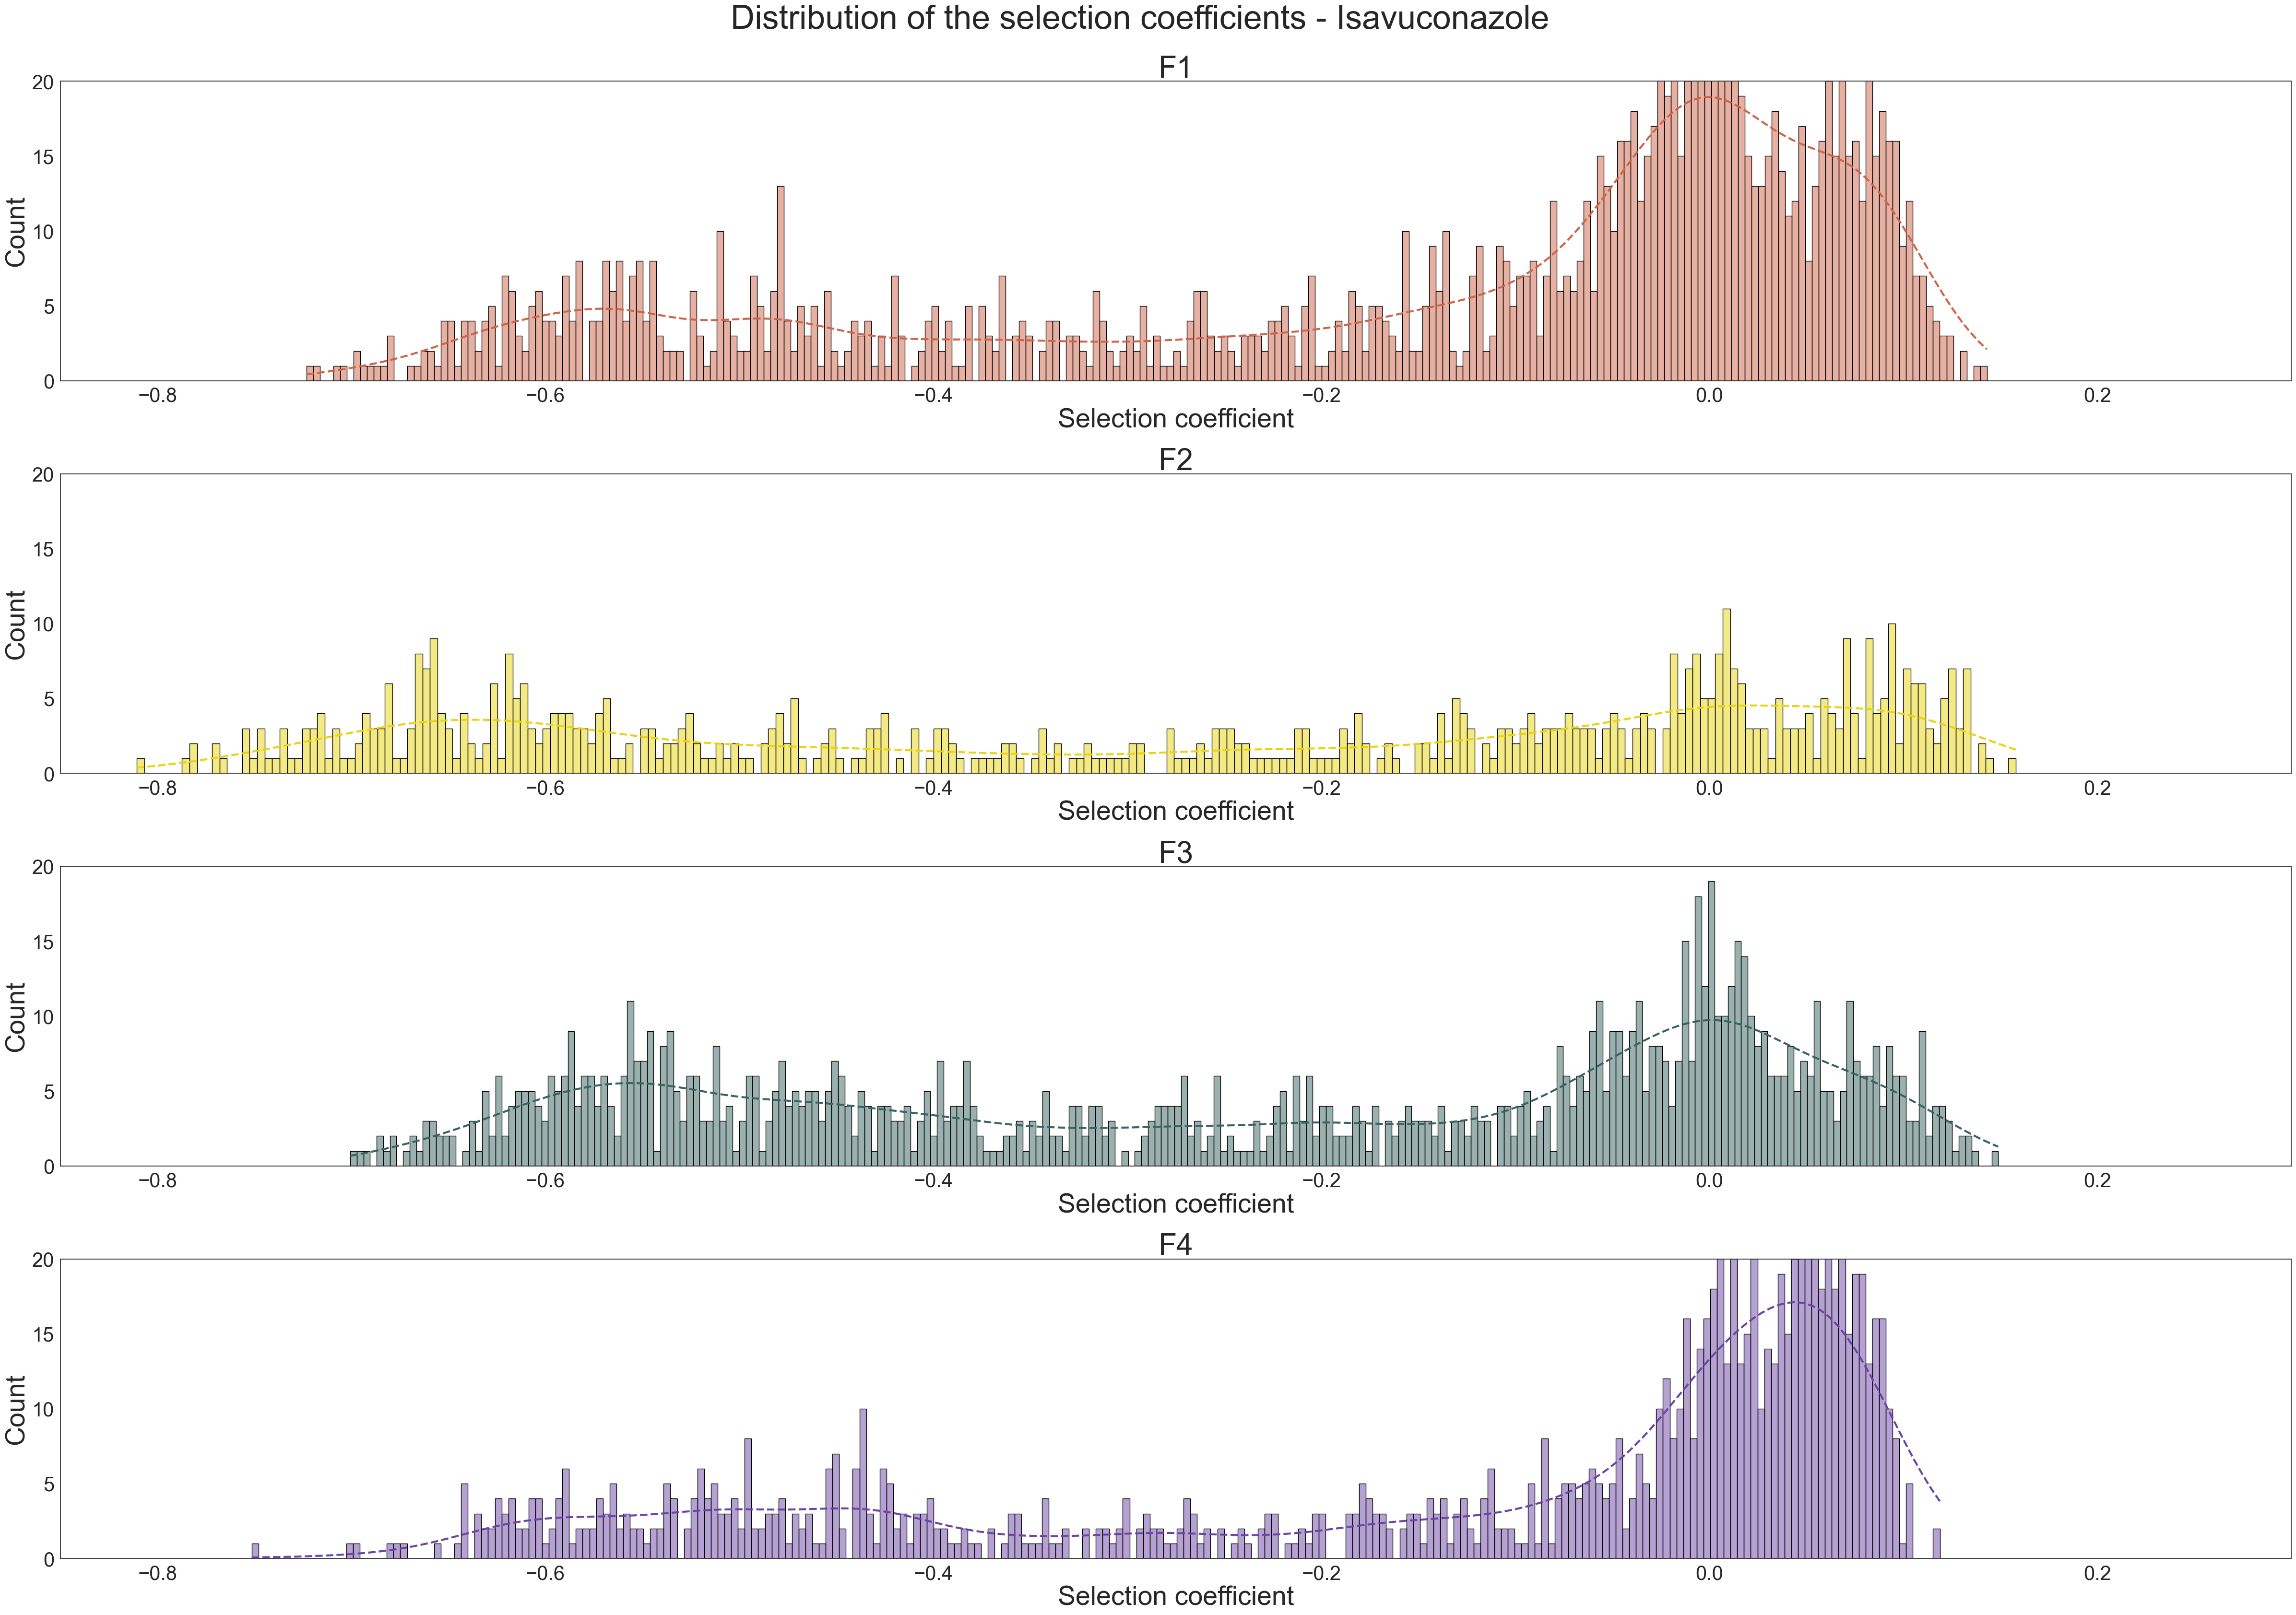

In [45]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 20)
    axes[row].set_xlim(-0.85, 0.3)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [46]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_20840\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_20840\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_20840\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_20840\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_

In [47]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

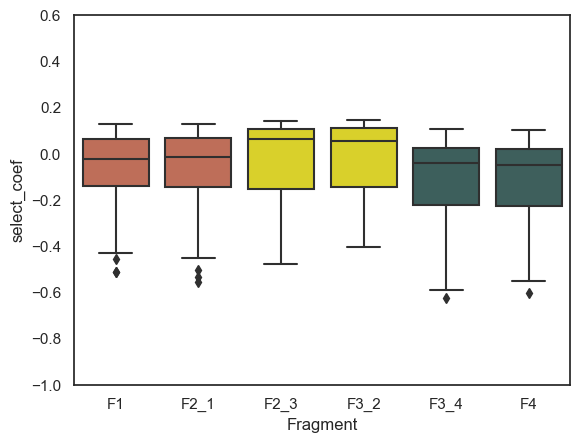

In [48]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

name = "Boxplot_overlaps_med_select_coef_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

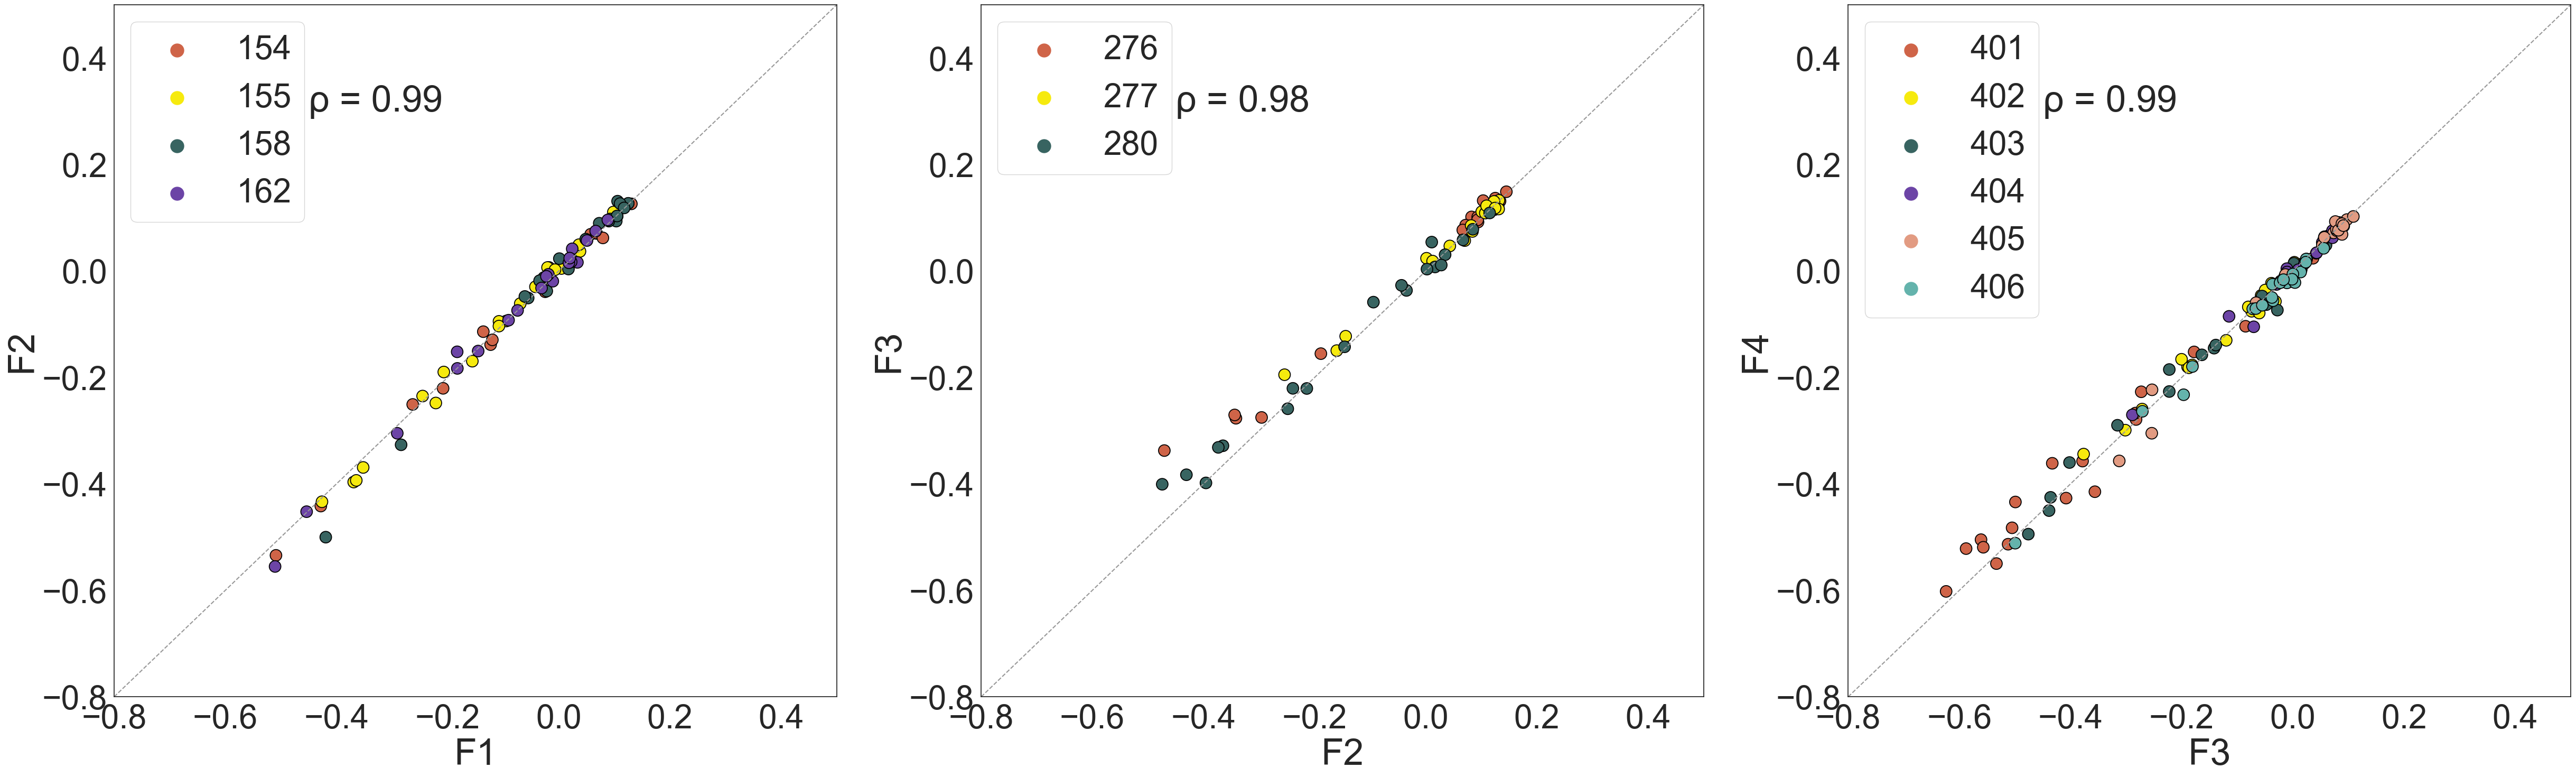

In [49]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    #axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) #+ "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [50]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = ["select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 7- Heatmaps !!

In [51]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [52]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

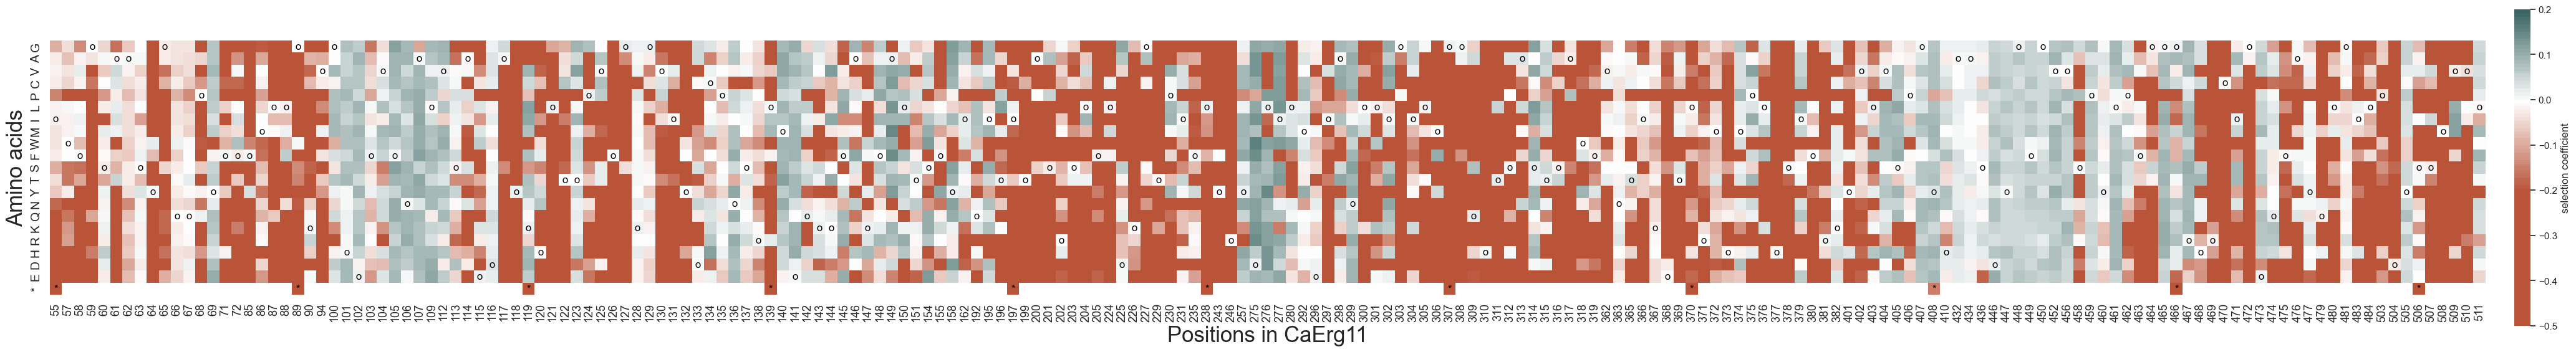

In [54]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True,  vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 8- t-test significant resistance

In [55]:
#import the df with the replicates, replicates are needed for t tests
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"

df_t = pd.read_csv(name, header=0)
df_t

Unnamed: 0  level_0  index  position codon Antifungal Fragment  \
0               0        0      0        55   AAA        Isa       F1   
1               1        1      3        55   AAC        Isa       F1   
2               2        2      6        55   AAG        Isa       F1   
3               3        3      9        55   AAT        Isa       F1   
4               4        4     12        55   ACC        Isa       F1   
...           ...      ...    ...       ...   ...        ...      ...   
23971        1975     1975  23963       511   TGT        Isa       F4   
23972        1976     1976  23966       511   TTA        Isa       F4   
23973        1977     1977  23969       511   TTC        Isa       F4   
23974        1978     1978  23972       511   TTG        Isa       F4   
23975        1979     1979  23975       511   TTT        Isa       F4   

      Replicate  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  \
0             A  0.000094  0.000006    380.0     21.0     0.0  11.055908   
1             A  0.000077  0.000024    312.0     80.0     0.0  11.055908   
2             A  0.000111  0.000002    447.0      6.0     0.0  11.055908   
3             A  0.000071  0.000019    288.0     65.0     0.0  11.055908   
4             A  0.000054  0.000042    218.0    142.0     0.0  11.055908   
...         ...       ...       ...      ...      ...     ...        ...   
23971         C  0.000119  0.000306    449.0    953.0     0.0  10.906684   
23972         C  0.000085  0.000180    320.0    561.0     0.0  10.906684   
23973         C  0.000073  0.000274    276.0    854.0     0.0  10.906684   
23974         C  0.000112  0.000192    423.0    598.0     0.0  10.906684   
23975         C  0.000077  0.000276    291.0    858.0     0.0  10.906684   

       l2fc_0_2 aa  select_coef    nbr_gen  
0     -3.866795  K    -0.361693  11.055908  
1     -1.702748  N    -0.165956  11.055908  
2     -5.752580  K    -0.532261  11.055908  
3     -1.883111  N    -0.182270  11.055908  
4     -0.367495  T    -0.045183  11.055908  
...         ... ..          ...        ...  
23971  1.360814  C     0.041805  10.906684  
23972  1.084747  L     0.016493  10.906684  
23973  1.902789  F     0.091497  10.906684  
23974  0.775242  L    -0.011885  10.906684  
23975  1.833440  F     0.085138  10.906684  

[23976 rows x 18 columns]

In [56]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [57]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [58]:
# get all the wts infos in our df fluco

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [59]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant        p_value  adjusted_p_value
0           55K  7.348719e-250     2.714845e-249
1           55N   5.969955e-82      1.386956e-81
2           55T   2.271340e-05      2.762382e-05
3           55R  1.303447e-266     5.239773e-266
4            WT   1.000000e+00      1.000000e+00
...         ...            ...               ...
3826       511Y  5.603300e-147     1.531116e-146
3827       511S   1.169397e-11      1.648863e-11
3828       511C   6.068426e-10      8.229430e-10
3829       511W   6.946691e-01      7.040417e-01
3830       511F   2.772904e-27      4.950138e-27

[3831 rows x 3 columns]


In [60]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [61]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [62]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [63]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT without antifungal")

1009 variant have an advantage
2375 variant have a deleterious substitution
638 variant are like the WT without antifungal


In [64]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
df_del_wt["select_coef"].quantile(0.95)
#df_del_wt["select_coef"].quantile(0.05)

0.01977498846873529

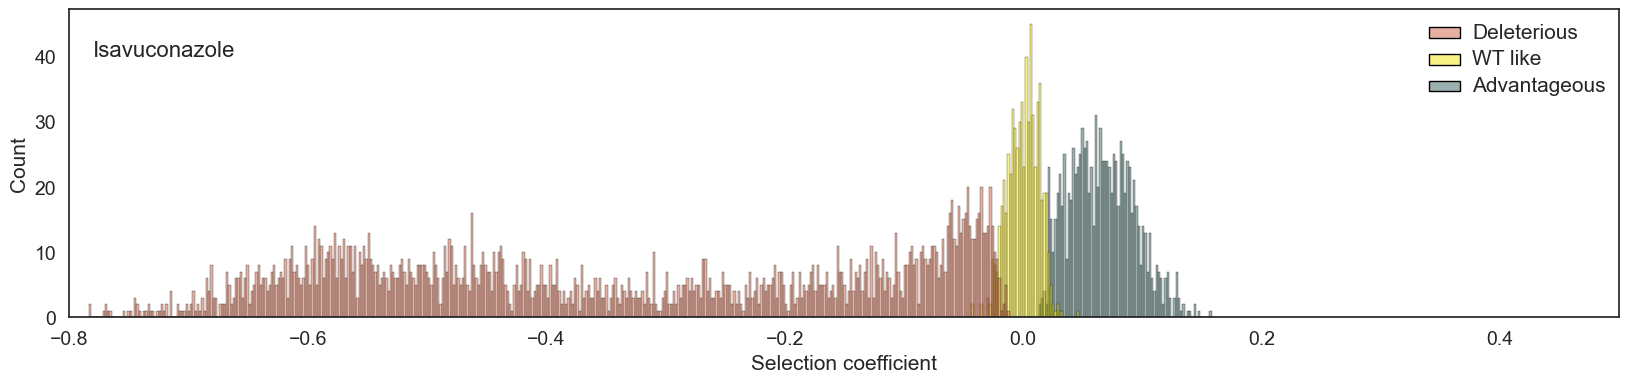

In [65]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,40, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [66]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55        Isa  *    -0.469618  1.574048e-209     5.132067e-209   
1           55        Isa  A    -0.029091   1.386181e-08      1.819273e-08   
2           55        Isa  C    -0.027665   7.117978e-05      8.567067e-05   
3           55        Isa  D    -0.373303  1.017307e-238     3.601942e-238   
4           55        Isa  E    -0.363802  2.608095e-234     9.050373e-234   
...        ...        ... ..          ...            ...               ...   
4017       511        Isa  S     0.049544   1.169397e-11      1.648863e-11   
4018       511        Isa  T     0.005901   3.999093e-01      4.159796e-01   
4019       511        Isa  V     0.034597   3.616407e-05      4.377396e-05   
4020       511        Isa  W    -0.000725   6.946691e-01      7.040417e-01   
4021       511        Isa  Y    -0.248302  5.603300e-147     1.531116e-146   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]